## (A modern) Time Series tutorial
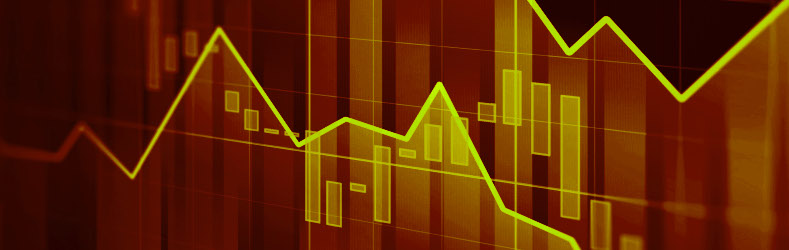

**Time Series** is a class of data science problems where the primary values of interest are a series of data points measured over a period of time. This notebook aims to provide the basic building blocks of some of the **more modern algorithms / techniques (and data!)** for solving these types of problems.

Is **ARIMA** the first thing you think of when you hear about time series? It might be time to explore other ventures and methodologies.
There is a lot of new innovation and modern techniques being actively developed and some of them are outperforming the traditional ARIMA models. We'll look at some of these models and try to apply them on stock market data to predict price.

Models explored in this notebook:
* **Auto ARIMAX**
* **Facebook Prophet**
* **LightGBM**
* **LSTM (coming soon)** 

The auto_arima module from *pmdarima* package is not directly available on Kaggle so we'll install it using pip.

In [ ]:
!pip install pmdarima

In [ ]:
import lightgbm as lgb
import numpy as np
import pandas as pd

from fbprophet import Prophet
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

myfavouritenumber = 13
seed = myfavouritenumber
np.random.seed(seed)

## Nifty-50 Stock Market Data
The [dataset](https://www.kaggle.com/rohanrao/nifty50-stock-market-data) used is stock market data of the Nifty-50 index from NSE (National Stock Exchange) India over the last 20 years (2000 - 2019)

The historic **VWAP (Volume Weighted Average Price)** is the target variable to predict. VWAP is a trading benchmark used by traders that gives the average price the stock has traded at throughout the day, based on both volume and price.   
Read more about the dataset: https://www.kaggle.com/rohanrao/nifty50-stock-market-data

The stock used is **BAJAJFINSV**.

## Data Preparation
Reading the market data of BAJAJFINSV stock and preparing a training dataset and validation dataset.

In [ ]:
df = pd.read_csv("/kaggle/input/nifty50-stock-market-data/BAJAJFINSV.csv")
df.set_index("Date", drop=False, inplace=True)
df.head()

Plotting the target variable **VWAP** over time

In [ ]:
df.VWAP.plot(figsize=(14, 7))

## Feature Engineering
Almost every time series problem will have some external features or some internal feature engineering to help the model.

Let's add some basic features like lag values of available numeric features that are widely used for time series problems. Since we need to predict the price of the stock for a day, we cannot use the feature values of the same day since they will be unavailable at actual inference time. We need to use statistics like mean, standard deviation of their lagged values.

We will use three sets of lagged values, one previous day, one looking back 7 days and another looking back 30 days as a proxy for last week and last month metrics.

In [ ]:
df.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume", "Turnover", "Trades"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Date", drop=False, inplace=True)
df.head()

For boosting models, it is very useful to add datetime features like hour, day, month, as applicable to provide the model information about the time component in the data. For time series models it is not explicitly required to pass this information but we could do so and we will in this notebook so that all models are compared on the exact same set of features.

In [ ]:
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek
df.head()

Splitting the data into train and validation along with features.     
* **train:** Data from 26th May, 2008 to 31st December, 2018.
* **valid:** Data from 1st January, 2019 to 31st December, 2019.

In [ ]:
df_train = df[df.Date < "2019"]
df_valid = df[df.Date >= "2019"]

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3", "Trades_mean_lag3", "Trades_std_lag3",
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7", "Trades_mean_lag7", "Trades_std_lag7",
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Turnover_std_lag30", "Trades_mean_lag30", "Trades_std_lag30",
                      "month", "week", "day", "day_of_week"]

The additional features supplied to time series problems are called exogenous regressors.

## Auto ARIMAX
ARIMA (Auto Regressive Integrated Moving Average) models explain a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

ARIMA models require certain input parameters: p for the AR(p) part, q for the MA(q) part and d for the I(d) part. Thankfully, there is an automatic process by which these parameters can be chosen which is called Auto ARIMA.

When exogenous regressors are used with ARIMA it is commonly called ARIMAX.

Read more about ARIMA: https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average

In [ ]:
model = auto_arima(df_train.VWAP, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.VWAP, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

The best ARIMA model is ARIMA(2, 0, 1) which has the lowest [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion).

In [ ]:
df_valid[["VWAP", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))

The Auto ARIMAX model seems to do a fairly good job in predicting the stock price given data till the previous day. Can other models beat this benchmark?

## Facebook Prophet
Prophet is an open-source time series model developed by Facebook. It was released in early 2017. An exerpt from the homepage:

> Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Read more about Prophet: https://facebook.github.io/prophet/

I also shared a starter code [Prophet's Prophecy](https://www.kaggle.com/rohanrao/ashrae-prophet-s-prophecy) for using Prophet in the ASHRAE competition on Kaggle.

Note that the default parameters are used for Prophet. They can be tuned to improve the results.

In [ ]:
model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds", "VWAP": "y"}))

forecast = model_fbp.predict(df_valid[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds"}))
df_valid["Forecast_Prophet"] = forecast.yhat.values

In [ ]:
model_fbp.plot_components(forecast)

In [ ]:
df_valid[["VWAP", "Forecast_ARIMAX", "Forecast_Prophet"]].plot(figsize=(14, 7))

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_Prophet)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_Prophet))

Auto ARIMAX performs better than Prophet in this case.

## LightGBM
Time series problems are popularly converted into a tabular i.i.d. structure and fed into boosting models like [LightGBM](https://lightgbm.readthedocs.io/en/latest/) and [XGBoost](https://xgboost.readthedocs.io/en/latest/).

There is loss of information in terms of knowing the order of data points in the time series but it can be circumvented by the datetime features to capture this information to some extent.

Note that the default parameters are used for LightGBM. They can be tuned to improve the results.

In [ ]:
params = {"objective": "regression"}

dtrain = lgb.Dataset(df_train[exogenous_features], label=df_train.VWAP.values)
dvalid = lgb.Dataset(df_valid[exogenous_features])

model_lgb = lgb.train(params, train_set=dtrain)

forecast = model_lgb.predict(df_valid[exogenous_features])
df_valid["Forecast_LightGBM"] = forecast

In [ ]:
df_valid[["VWAP", "Forecast_ARIMAX", "Forecast_Prophet", "Forecast_LightGBM"]].plot(figsize=(14, 7))

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_Prophet)))
print("RMSE of LightGBM:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_LightGBM)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_Prophet))
print("MAE of LightGBM:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_LightGBM))

LightGBM performs terribly! This is a very important aspect of using boosting models for time series. Remember that boosting models are constrained to predict within the range of target values appearing in the training data. The maximum price value in the training data is ~ 7100 and hence LGBM is unable to predict values beyond 7100.

Then why are boosting methods still so popular? Well, they fail only in cases where the trend component is extremely strong and there are a wide variety of use cases where the trend is weak and the expected forecasts are within the values of the past. Stock prices is an example that generally has strong trend components especially when measured over years.

One method of improving i.i.d. based models is to model the differential target variable after removing the trend and making the time series stationary. We will look at this process along with an example of using a deep learning model (LSTM) to build a time series solution.

Will be updated soon.

## Conclusions and Tips
* Auto ARIMAX is a great baseline model but newer algorithms like Facebook's Prophet are extremely powerful and are getting cleverer by the day. Don't feel afraid to try out new techniques.
* Setting up an appropriate validation framework is extremely important. It enables you to try and experiment various models and objectively compare them.
* Lag-based features are very useful in providing trends information about the time series data. Rolling statistics are a common way of generating these.
* Exogenous regressors help in providing external information about the time series. They tend to be very important in most models.
* Boosting models like LightGBM are constrained to predict within the range of values of the target variable in the training data and don't extrapolate when there is strong trend.
* Converting a time series to stationary and then modelling is a common approach for building solutions and can significantly improve results.